In [8]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [9]:
SPLITS = {
    'train': ('2024-01-16', '2024-06-30'),
    'validate': ('2024-07-01', '2024-08-31'), 
    'test': ('2024-09-01', '2025-01-14')
}

split_name = 'train'
model_name = "xgboost"
run_name = "kevin"
# Convert dates to datetime for comparison
split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
split_end = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
# Adjust this path to your inference CSV files.
data_pattern = f'/Users/raghuvar/Code/dataBAM/inference/{model_name}/{run_name}*/inference/*.5min.csv'



In [10]:
metrics = {
  "train_rmse": 0.48345229029655457,
  "train_rank_corr": 0.877302529568411,
  "val_rmse": 0.9618895053863525,
  "val_rank_corr": 0.6518252365878696,
  "feature_importance": {
    "mid": 0.033925946801900864,
    "spread": 0.01841839775443077,
    "log_ret_1m": 0.03641923889517784,
    "log_ret_5m": 0.06506500393152237,
    "imbalance": 0.032263293862342834,
    "log_turnover": 0.03932695463299751,
    "roll_vol_5m": 0.2725801467895508,
    "roll_vol_30m": 0.18631115555763245,
    "vol_of_vol_5m": 0.04614085704088211,
    "vol_regime": 0.011260312981903553,
    "rel_vol": 0.04012421891093254,
    "vol_rank": 0.07159712165594101,
    "bid_sz_00": 0.014191694557666779,
    "ask_sz_00": 0.014035760425031185,
    "spread_ma_10m": 0.02732965722680092,
    "imbalance_ma_10m": 0.011195061728358269,
    "normalized_time": 0.015471288003027439,
    "time_cos": 0.035775117576122284,
    "time_sin": 0.014189407229423523,
    "avg_nn_roll_vol_5m": 0.006388375069946051,
    "avg_nn_log_ret_5m": 0.007991035468876362
  },
  "step": 200
}

params = {
  "n_estimators": 200,
  "max_depth": 4,
  "subsample": 0.8,
  "colsample_bytree": 0.8,
  "tree_method": "hist",
  "device": "cpu"
}

In [14]:
# %%
def load_file(filepath):
    """
    Load a CSV file and extract the date (using the first 8 characters of the filename).
    """
    df = pd.read_csv(filepath)
    # Assume filename starts with YYYYMMDD
    file_date = os.path.basename(filepath)[:8]
    df['date'] = pd.to_datetime(file_date, format='%Y%m%d', errors='coerce')
    return df

def load_split_data(split_name, data_pattern):
    """
    Load and concatenate all CSV files (matching data_pattern) that fall into the
    specified split period.
    """
    split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
    split_end   = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
    
    all_files = glob.glob(data_pattern)
    dfs = []
    for f in all_files:
        try:
            file_date = datetime.strptime(os.path.basename(f)[:8], '%Y%m%d')
        except Exception as e:
            print(f"Error parsing date from {f}: {e}")
            continue
        if split_start <= file_date <= split_end:
            dfs.append(load_file(f))
            
    if dfs:
        print(f"Loaded {len(dfs)} files for split '{split_name}'.")
        return pd.concat(dfs, ignore_index=True)
    else:
        print(f"No files found for split '{split_name}'.")
        return pd.DataFrame()

# %%
def add_time_features(df):
    """
    Add time features based on the 'minute' column (assumed format "HH:MM").
    Creates:
      - hour
      - minute_in_hour
      - minutes_from_open (assuming market opens at 9:30)
    """
    df = df.copy()
    df['hour'] = df['minute'].str[:2].astype(int)
    df['minute_in_hour'] = df['minute'].str[3:].astype(int)
    # Calculate minutes from market open (market opens at 9:30)
    df['minutes_from_open'] = (df['hour'] - 9) * 60 + df['minute_in_hour'] - 30
    return df

# =============================================================================
# Missing Data Analysis
# =============================================================================
# %%
def analyze_missing_predictions(df):
    """
    Analyze missing predicted values for volatility.
    Reports the overall missing percentage and plots missing counts by hour.
    """
    missing_mask = df['predicted.volatility'].isna()
    n_missing = missing_mask.sum()
    total = len(df)
    print(f"Missing predicted.volatility: {n_missing} / {total} rows ({100 * n_missing/total:.2f}%).")
    
    # Group missing counts by hour.
    missing_by_hour = df[missing_mask].groupby('hour').size()
    
    plt.figure(figsize=(8, 4))
    plt.bar(missing_by_hour.index.astype(str), missing_by_hour.values, color='skyblue')
    plt.title("Missing Predictions by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count of Missing Predictions")
    plt.tight_layout()
    plt.show()
    
    # Report missing counts by symbol.
    missing_by_symbol = df[missing_mask].groupby('symbol').size()
    print("\nSymbols with missing predictions (top 10):")
    print(missing_by_symbol.nlargest(10))
    return missing_by_hour, missing_by_symbol

# %%
def analyze_late_missing(df, symbol='A', min_minute='10:00'):
    """
    Analyze missing predictions for a specific symbol after a given time.
    """
    missing_mask = df['predicted.volatility'].isna()
    symbol_missing = df[(df['symbol'] == symbol) & missing_mask & (df['minute'] > min_minute)]
    late_missing = symbol_missing.sort_values('minute', ascending=False)[['date', 'minute', 'Y_log_vol_10min_lag_1m']]
    print(f"\nMissing predictions for {symbol} after {min_minute}:")
    print(late_missing.head(20))
    return late_missing

# =============================================================================
# Metrics and Error Analysis
# =============================================================================
# %%
def compute_overall_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute overall RMSE, MAE, Pearson correlation, and Spearman correlation.
    Handles extreme values and outliers.
    """
    # Get valid data, removing NaN and infinite values
    valid = df[[target_col, pred_col]].copy()
    valid = valid[np.isfinite(valid[target_col]) & 
                 np.isfinite(valid[pred_col])]
    
    # Remove extreme outliers (optional) - values beyond 5 standard deviations
    for col in [target_col, pred_col]:
        mean = valid[col].mean()
        std = valid[col].std()
        valid = valid[abs(valid[col] - mean) <= 5 * std]
    
    if len(valid) == 0:
        print("No valid data points after filtering!")
        return {
            'rmse': np.nan,
            'mae': np.nan,
            'pearson_corr': np.nan,
            'spearman_corr': np.nan
        }
    
    # Compute metrics
    error = valid[pred_col] - valid[target_col]
    
    try:
        mse = np.mean(error**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(error))
    except:
        rmse = np.nan
        mae = np.nan
    
    try:
        pearson_corr = np.corrcoef(valid[pred_col], valid[target_col])[0, 1]
    except:
        pearson_corr = np.nan
    
    try:
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0, 1]
    except:
        spearman_corr = np.nan
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr
    }
    
    # Print diagnostics
    print("\nData Quality Summary:")
    print(f"Original rows: {len(df)}")
    print(f"Valid rows after filtering: {len(valid)}")
    print(f"\nValue ranges:")
    print(f"Target: [{valid[target_col].min():.4f}, {valid[target_col].max():.4f}]")
    print(f"Predictions: [{valid[pred_col].min():.4f}, {valid[pred_col].max():.4f}]")
    
    print("\nOverall Metrics:")
    for k, v in metrics.items():
        if np.isfinite(v):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")
    
    return metrics
# %%
def analyze_predictions(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze the relationship between predicted and actual volatility.
    Produces a scatter plot and error histogram.
    """
    metrics = compute_overall_metrics(df, target_col, pred_col)
    df = df.copy()
    df['abs_error'] = np.abs(df[pred_col] - df[target_col])
    
    # Scatter plot: Actual vs. Predicted
    valid = df.dropna(subset=[target_col, pred_col])
    plt.figure(figsize=(8, 6))
    plt.scatter(valid[target_col], valid[pred_col], alpha=0.3, color='darkorange')
    plt.plot([valid[target_col].min(), valid[target_col].max()],
             [valid[target_col].min(), valid[target_col].max()], 'r--')
    plt.title("Predicted vs. Actual Volatility")
    plt.xlabel("Actual Volatility")
    plt.ylabel("Predicted Volatility")
    plt.tight_layout()
    plt.show()
    
    # Filter out any infinite values from absolute error before plotting.
    abs_errors = df['abs_error'][np.isfinite(df['abs_error'])]
    
    # Histogram of absolute error.
    plt.figure(figsize=(8, 4))
    plt.hist(abs_errors, bins=50, color='lightgreen', edgecolor='black')
    plt.title("Distribution of Absolute Error")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    return metrics

# %%
def analyze_regimes(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Divide data into volatility regimes (using quantiles of the target)
    and compute RMSE and Spearman correlation in each regime.
    """
    df = df.copy()
    df['vol_regime'] = pd.qcut(df[target_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    valid_data = df[np.isfinite(df[target_col])]
    if len(valid_data) == 0:
        print("No valid data for regime analysis")
        return pd.DataFrame()
    
    def regime_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({'rmse': np.nan, 'spearman_corr': np.nan, 'n_obs': len(valid)})
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0, 1]
        return pd.Series({'rmse': rmse_val, 'spearman_corr': spearman_corr, 'n_obs': len(valid)})
    
    # Add observed=True to address the FutureWarning
    regime_metrics_df = df.groupby('vol_regime', observed=True).apply(regime_metrics)
    print("\nMetrics by Volatility Regime:")
    print(regime_metrics_df)
    
    regime_metrics_df[['rmse', 'spearman_corr']].plot(kind='bar', subplots=True,
                                                     layout=(1,2), figsize=(14,4), legend=False)
    plt.suptitle("Metrics by Volatility Regime")
    plt.tight_layout()
    plt.show()
    
    return regime_metrics_df

# %%
def analyze_intraday_pattern(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze intraday performance by grouping by minute of day.
    """
    df = df.copy()
    if 'hour' not in df.columns or 'minute_in_hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
        df['minute_in_hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.minute
    df['minute_of_day'] = df['hour'] * 60 + df['minute_in_hour']
    
    intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({
        'rmse': np.sqrt(np.mean((x[pred_col] - x[target_col])**2)),
        'spearman_corr': np.corrcoef(x[pred_col].rank().values, x[target_col].rank().values)[0,1] if len(x) > 1 else np.nan,
        'n_obs': len(x)
    })).reset_index()
    
    plt.figure(figsize=(12, 4))
    plt.plot(intraday['minute_of_day'], intraday['rmse'], marker='o', linestyle='-')
    plt.title("Intraday RMSE Pattern")
    plt.xlabel("Minute of Day")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()
    
    return intraday

# %%
def compute_symbol_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute per-symbol metrics: RMSE, Pearson and Spearman correlations.
    """
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({'rmse': np.nan, 'pearson_corr': np.nan, 
                              'spearman_corr': np.nan, 'n_obs': len(valid)})
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
           # Handle potential division by zero or invalid correlations
        try:
            pearson_corr = np.corrcoef(valid[pred_col], valid[target_col])[0, 1]
        except:
            pearson_corr = np.nan

        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        return pd.Series({'rmse': rmse_val, 'pearson_corr': pearson_corr, 
                          'spearman_corr': spearman_corr, 'n_obs': len(valid)})
    
    symbol_metrics = df.groupby('symbol').apply(compute_metrics)
    return symbol_metrics

# =============================================================================
# Data Quality and Symbol-Level Performance
# =============================================================================
# %%
def check_data_quality(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Perform basic data quality checks and produce a sample time series plot.
    """
    print("Data Quality Checks:")
    print(f"  Total rows: {len(df)}")
    print("  Missing values:")
    print(df[[pred_col, target_col]].isna().sum())
    print("\nDescriptive Statistics:")
    print(df[[pred_col, target_col]].describe())
    
    # Show a sample of data for the first symbol.
    sample_symbol = df['symbol'].iloc[0]
    sample_data = df[df['symbol'] == sample_symbol].head(10)
    print(f"\nSample data for symbol {sample_symbol}:")
    print(sample_data[['minute', pred_col, target_col]])
    
    if not sample_data.empty:
        plt.figure(figsize=(10, 4))
        plt.plot(sample_data['minute'], sample_data[target_col], label="Actual", marker='o')
        plt.plot(sample_data['minute'], sample_data[pred_col], label="Predicted", linestyle='--', marker='x')
        plt.title(f"Time Series for {sample_symbol}")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# %%
def analyze_symbol_performance(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze per-symbol performance after filtering out early market minutes.
    """
    df = df.copy()
    # Convert 'minute' to datetime and extract hour/minute.
    df['minute_dt'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce')
    df['hour'] = df['minute_dt'].dt.hour
    df['minute_int'] = df['minute_dt'].dt.minute
    df['minutes_from_open'] = (df['hour'] - 9) * 60 + df['minute_int'] - 30
    
    # Filter out data before 30 minutes after market open.
    df_clean = df[df['minutes_from_open'] >= 30].copy()
    
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({'rmse': np.nan, 'spearman_corr': np.nan, 'n_obs': len(valid)})
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        return pd.Series({'rmse': rmse_val, 'spearman_corr': spearman_corr, 'n_obs': len(valid)})
    
    symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)
    
    print("\nSymbol-Level Performance Summary:")
    print(symbol_perf.describe())
    
    # Filter out any non-finite values before plotting the histogram.
    rmse_values = symbol_perf['rmse'].dropna()
    rmse_values = rmse_values[np.isfinite(rmse_values)]
    
    plt.figure(figsize=(8, 4))
    plt.hist(rmse_values, bins=50, color='lightblue', edgecolor='black')
    plt.title("Distribution of Symbol-Level RMSE")
    plt.xlabel("RMSE")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    top_symbols = symbol_perf.sort_values('spearman_corr', ascending=False).head(10)
    print("\nTop 10 symbols by Spearman correlation:")
    print(top_symbols)
    
    return symbol_perf

# =============================================================================
# Analysis of Lag Effects
# =============================================================================
# %%
def analyze_lag_effects(df, pred_col='predicted.volatility', 
                        target_no_lag='Y_log_vol_10min', 
                        target_with_lag='Y_log_vol_10min_lag_1m'):
    """
    Compare prediction performance for targets with and without lag.
    """
    print("\nAnalyzing Lag Effects:")
    metrics_no_lag = compute_overall_metrics(df, target_col=target_no_lag, pred_col=pred_col)
    metrics_with_lag = compute_overall_metrics(df, target_col=target_with_lag, pred_col=pred_col)
    
    print("\nMetrics for target without lag (Y_log_vol_10min):")
    for k, v in metrics_no_lag.items():
        print(f"  {k}: {v:.4f}")
    
    print("\nMetrics for target with lag (Y_log_vol_10min_lag_1m):")
    for k, v in metrics_with_lag.items():
        print(f"  {k}: {v:.4f}")
        
    return metrics_no_lag, metrics_with_lag

In [15]:
# =============================================================================
# Main Analysis
# =============================================================================
# %%
# Load data for the chosen split.
df = load_split_data(split_name, data_pattern)
if df.empty:
    raise ValueError("No data loaded. Check your file paths and date ranges.")

# Add time features.
df = add_time_features(df)


Loaded 115 files for split 'train'.


Missing predicted.volatility: 0 / 7851907 rows (0.00%).


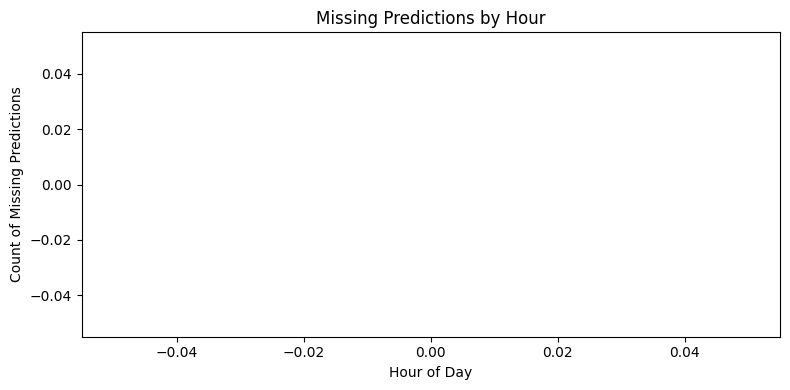


Symbols with missing predictions (top 10):
Series([], dtype: int64)

Missing predictions for A after 10:00:
Empty DataFrame
Columns: [date, minute, Y_log_vol_10min_lag_1m]
Index: []
Data Quality Checks:
  Total rows: 7851907
  Missing values:
predicted.volatility      0
Y_log_vol_10min_lag_1m    0
dtype: int64

Descriptive Statistics:
       predicted.volatility  Y_log_vol_10min_lag_1m
count          7.851907e+06            7.851907e+06
mean                    inf            6.988477e-04
std                     NaN            1.327302e-03
min           -9.998382e-01            0.000000e+00
25%           -3.491751e-01            3.132678e-04
50%           -1.944781e-01            4.957088e-04
75%            1.770826e-01            8.060710e-04
max                     inf            1.334344e+00

Sample data for symbol A:
  minute  predicted.volatility  Y_log_vol_10min_lag_1m
0  09:40              2.289835                0.001617
1  09:45              1.374808                0.000997
2 

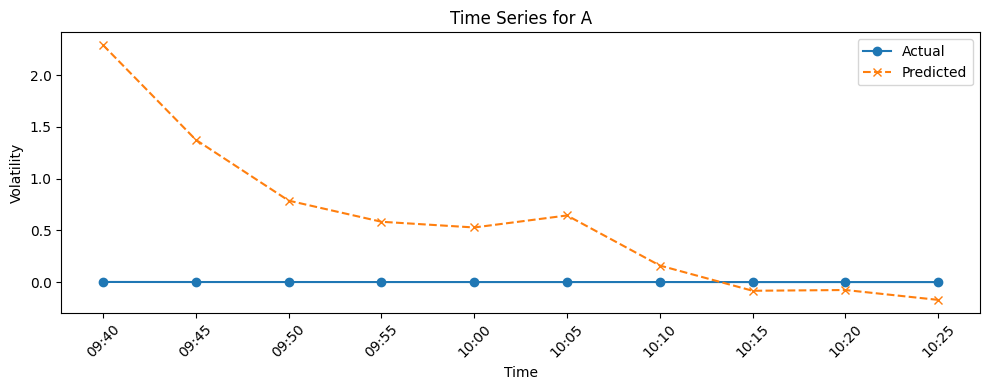


Data Quality Summary:
Original rows: 7851907
Valid rows after filtering: 7835111

Value ranges:
Target: [0.0000, 0.0073]
Predictions: [-0.9998, 3622049300000000180224.0000]

Overall Metrics:
  rmse: 1386964261447106048.0000
  mae: 955500352687837.7500
  pearson_corr: 0.0009
  spearman_corr: 0.7972


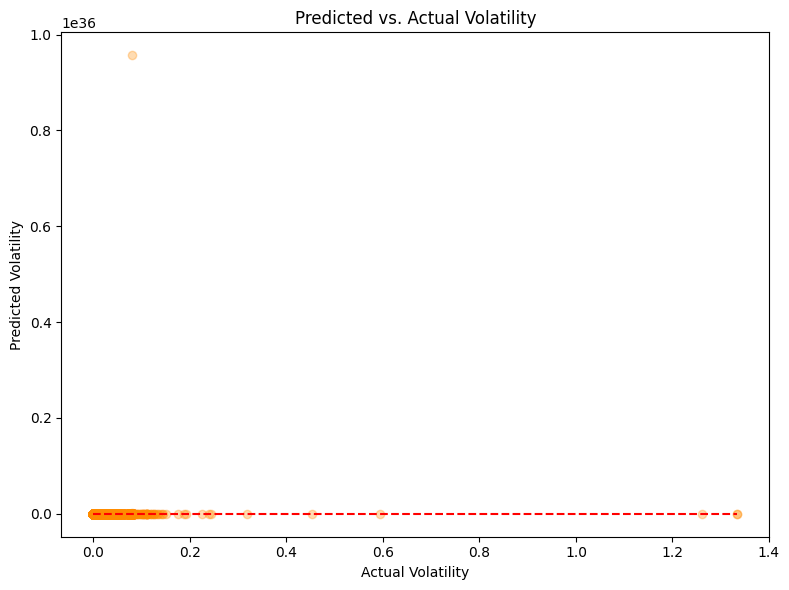

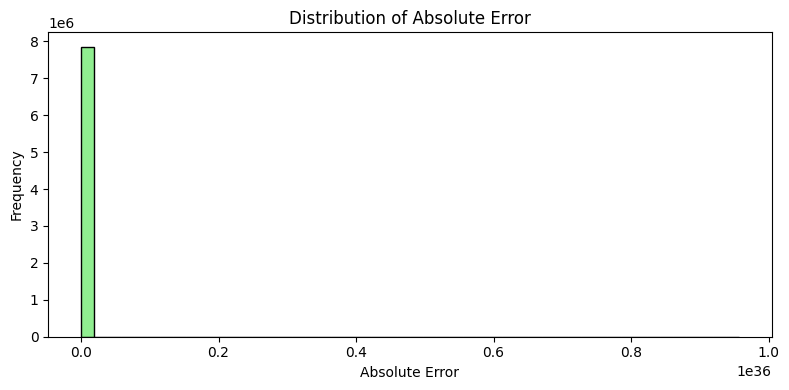


Metrics by Volatility Regime:
                    rmse  spearman_corr      n_obs
vol_regime                                        
Very Low    5.902558e+09       0.383570  1570382.0
Low         1.488199e+09       0.216554  1570381.0
Medium      5.640838e+12       0.216806  1570381.0
High        5.363719e+22       0.280357  1570381.0
Very High            inf       0.612471  1570382.0


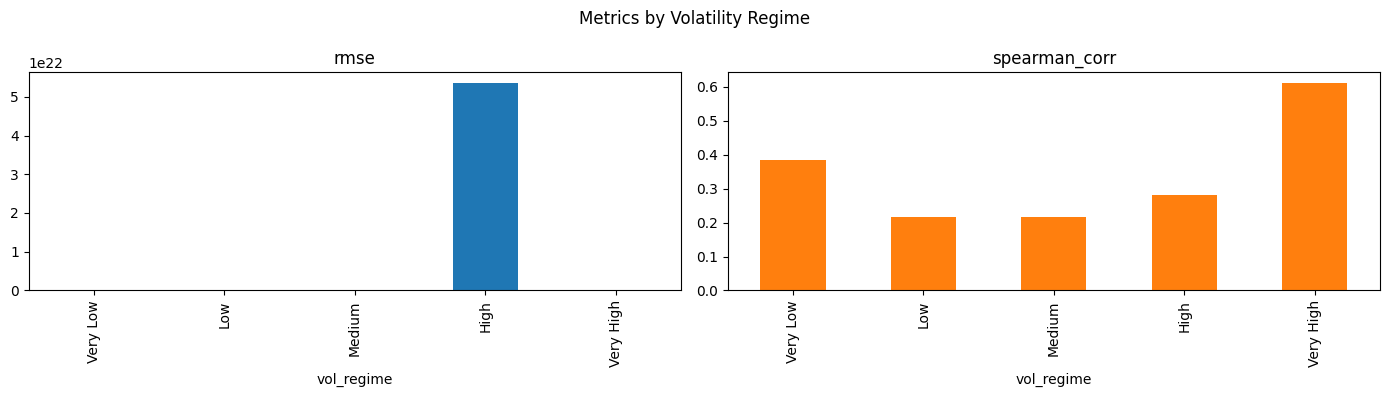

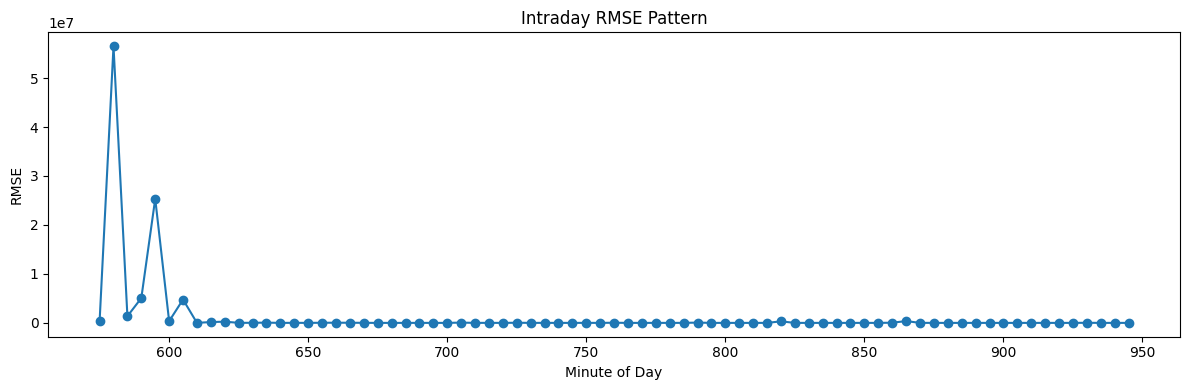


Symbol Metrics:
                rmse  pearson_corr  spearman_corr   n_obs
symbol                                                   
A       4.937449e+04      0.036493       0.663161  8400.0
AA      3.331950e+10      0.002171       0.691670  8653.0
AAL     1.188720e+09      0.013870       0.658637  8641.0
AAOI    3.980143e+02      0.318421       0.639906  2049.0
AAON    2.075068e+05      0.027326       0.502502  4569.0
...              ...           ...            ...     ...
ZM      3.336362e+01      0.050353       0.678861  8653.0
ZS      7.264337e+03      0.015418       0.702535  8551.0
ZTO     1.854522e+01      0.347812       0.669828  2931.0
ZTS     2.096491e+03      0.050628       0.671738  8541.0
ZVZZT   2.632245e+05     -0.027719       0.382142   118.0

[1555 rows x 4 columns]

Symbol-Level Performance Summary:
               rmse  spearman_corr        n_obs
count  1.555000e+03    1555.000000  1555.000000
mean            inf       0.529704  4719.478457
std             NaN      

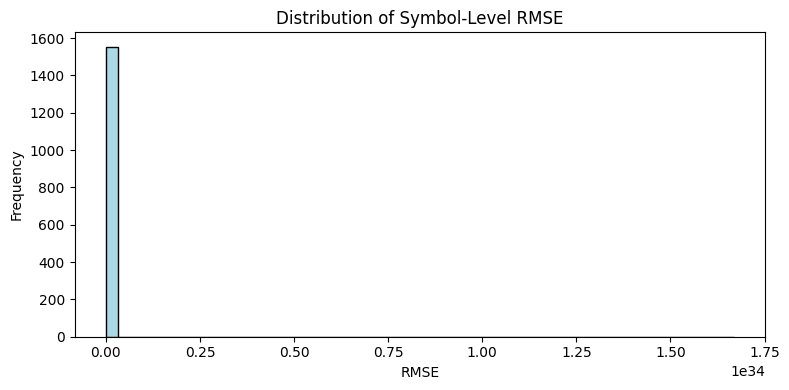


Top 10 symbols by Spearman correlation:
                rmse  spearman_corr   n_obs
symbol                                     
HCP     1.636305e+05       0.861612  6582.0
ALPN    2.784641e+03       0.833939  2667.0
AY      5.109357e+00       0.822050  1079.0
SWAV    1.863312e+04       0.814031  5611.0
WIRE    1.354010e+02       0.783751  4759.0
GL      2.019470e+05       0.765932  4419.0
DELL    2.738797e+04       0.745430  8129.0
KBE     7.052882e+06       0.740354  6482.0
IJR     3.345164e+02       0.736008  8092.0
ARM     1.025816e+04       0.735529  8153.0

Analyzing Lag Effects:

Data Quality Summary:
Original rows: 7851907
Valid rows after filtering: 7838436

Value ranges:
Target: [0.0000, 0.0067]
Predictions: [-0.9998, 1163971600000000019268777799581696.0000]

Overall Metrics:
  rmse: 415745613429274218048692158464.0000
  mae: 148495400603210718759616512.0000
  pearson_corr: -0.0000
  spearman_corr: 0.8023

Data Quality Summary:
Original rows: 7851907
Valid rows after filterin

In [16]:

# Analyze missing predictions.
analyze_missing_predictions(df)
analyze_late_missing(df)

# Perform basic data quality checks.
check_data_quality(df)

# Analyze overall predictions vs. actual volatility.
overall_metrics = analyze_predictions(df)

# Analyze performance across volatility regimes.
regime_metrics = analyze_regimes(df)

# Analyze intraday error patterns.
intraday_metrics = analyze_intraday_pattern(df)

# Compute cross-sectional (symbol-level) metrics.
symbol_metrics = compute_symbol_metrics(df)
print("\nSymbol Metrics:")
print(symbol_metrics)

# Analyze symbol-level performance.
symbol_perf = analyze_symbol_performance(df)

# Compare performance for targets with and without lag.
lag_metrics_no_lag, lag_metrics_with_lag = analyze_lag_effects(df)

# Optionally, save the summaries to CSV files.
symbol_metrics.to_csv("symbol_metrics_summary.csv", index=True)
symbol_perf.to_csv("symbol_performance.csv", index=True)

# Final summaries.
print("\nOverall Metrics:")
print(overall_metrics)
print("\nRegime Metrics:")
print(regime_metrics)
print("\nIntraday Metrics (first 10 rows):")
print(intraday_metrics.head(10))
print("\nTop 10 Symbols by Spearman Correlation:")
print(symbol_perf.sort_values('spearman_corr', ascending=False).head(10))


In [17]:
# Clip predictions at the 99th percentile
threshold = df['predicted.volatility'].quantile(0.99)
df['clipped_predictions'] = df['predicted.volatility'].clip(upper=threshold)

# Recalculate overall metrics using the clipped predictions:
overall_metrics_clipped = compute_overall_metrics(df, 
    target_col='Y_log_vol_10min_lag_1m', 
    pred_col='clipped_predictions')
print("Overall metrics with clipped predictions:")
for k, v in overall_metrics_clipped.items():
    print(f"  {k}: {v:.4f}")



Data Quality Summary:
Original rows: 7851907
Valid rows after filtering: 7735773

Value ranges:
Target: [0.0000, 0.0073]
Predictions: [-0.9998, 16.4852]

Overall Metrics:
  rmse: 1.5090
  mae: 0.6230
  pearson_corr: 0.6616
  spearman_corr: 0.7923
Overall metrics with clipped predictions:
  rmse: 1.5090
  mae: 0.6230
  pearson_corr: 0.6616
  spearman_corr: 0.7923


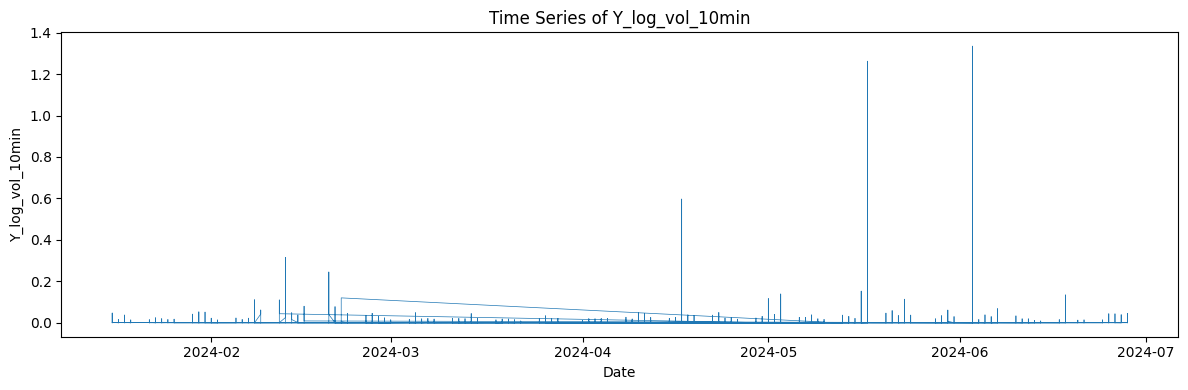

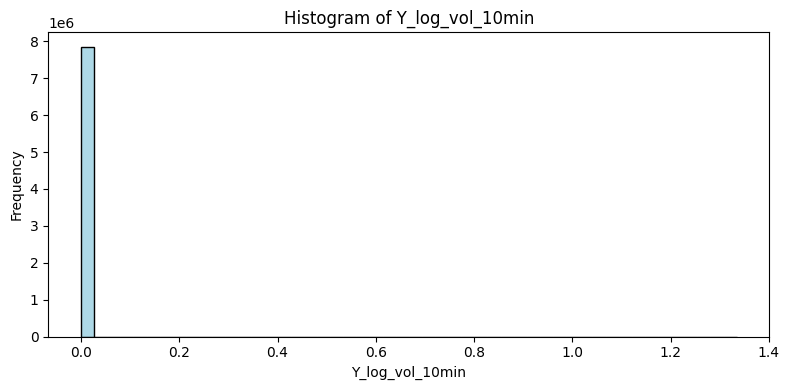

Descriptive statistics for Y_log_vol_10min:
count    7.851907e+06
mean     6.870756e-04
std      1.199272e-03
min      0.000000e+00
25%      3.152819e-04
50%      4.973449e-04
75%      8.060716e-04
max      1.334344e+00
Name: Y_log_vol_10min, dtype: float64

Descriptive statistics for Y_log_ret_10min:
count    7.851531e+06
mean    -8.611409e-06
std      4.078381e-03
min     -4.221156e+00
25%     -1.059391e-03
50%      1.425726e-17
75%      1.074460e-03
max      1.784463e+00
Name: Y_log_ret_10min, dtype: float64


In [18]:
# Plot the time series of 10-minute log volatility.
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['Y_log_vol_10min'], lw=0.5)
plt.title("Time Series of Y_log_vol_10min")
plt.xlabel("Date")
plt.ylabel("Y_log_vol_10min")
plt.tight_layout()
plt.show()

# Plot the histogram of Y_log_vol_10min.
plt.figure(figsize=(8, 4))
plt.hist(df['Y_log_vol_10min'].dropna(), bins=50, color='lightblue', edgecolor='black')
plt.title("Histogram of Y_log_vol_10min")
plt.xlabel("Y_log_vol_10min")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Print descriptive statistics for volatility and returns.
print("Descriptive statistics for Y_log_vol_10min:")
print(df['Y_log_vol_10min'].describe())
print("\nDescriptive statistics for Y_log_ret_10min:")
print(df['Y_log_ret_10min'].describe())


KeyboardInterrupt: 

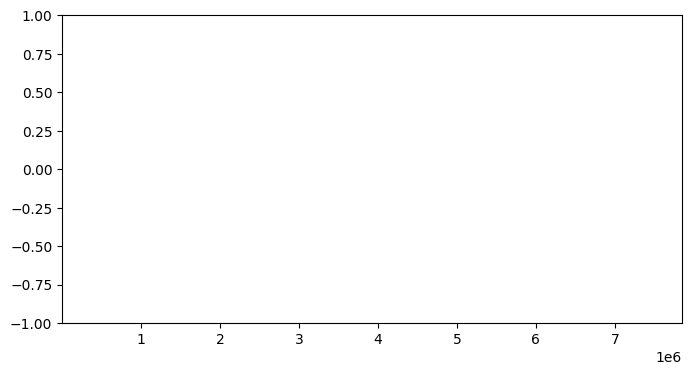

In [19]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(8, 4))
autocorrelation_plot(df['Y_log_vol_10min'].dropna())
plt.title("Autocorrelation Plot for Y_log_vol_10min")
plt.tight_layout()
plt.show()


In [ ]:
# Now, we compute and plot the autocorrelation coefficients manually for lags 1 to 20.
vol_series = df['Y_log_vol_10min'].dropna().values
lags = np.arange(1, 21)
autocorrs = [np.corrcoef(vol_series[:-lag], vol_series[lag:])[0, 1] for lag in lags]

plt.figure(figsize=(8, 4))
plt.stem(lags, autocorrs, use_line_collection=True)
plt.title("Autocorrelation Coefficients for Y_log_vol_10min")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


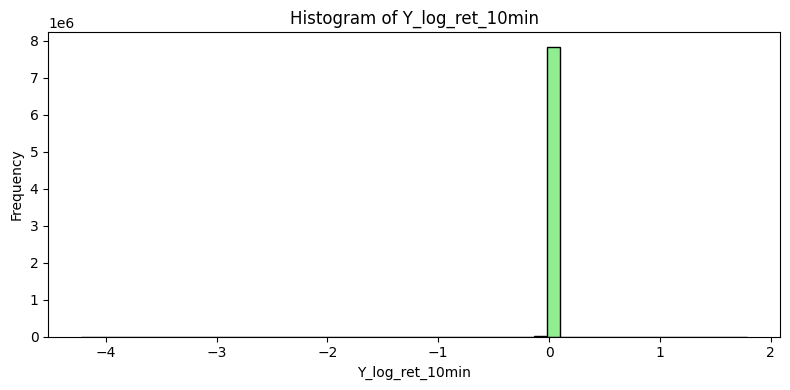

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 800x400 with 0 Axes>

In [20]:
# Plot the histogram of Y_log_ret_10min.
plt.figure(figsize=(8, 4))
plt.hist(df['Y_log_ret_10min'].dropna(), bins=50, color='lightgreen', edgecolor='black')
plt.title("Histogram of Y_log_ret_10min")
plt.xlabel("Y_log_ret_10min")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Compute and plot the autocorrelation for Y_log_ret_10min.
ret_series = df['Y_log_ret_10min'].dropna().values
lags_ret = np.arange(1, 21)
autocorrs_ret = [np.corrcoef(ret_series[:-lag], ret_series[lag:])[0, 1] for lag in lags_ret]

plt.figure(figsize=(8, 4))
plt.stem(lags_ret, autocorrs_ret, use_line_collection=True)
plt.title("Autocorrelation Coefficients for Y_log_ret_10min")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


In [ ]:
# First, align the two series by dropping any rows with missing values in either column.
common_idx = df.dropna(subset=['Y_log_vol_10min', 'Y_log_ret_10min']).index
vol_series_aligned = df.loc[common_idx, 'Y_log_vol_10min'].values
ret_series_aligned = df.loc[common_idx, 'Y_log_ret_10min'].values

max_lag = 20
lags_cross = np.arange(-max_lag, max_lag + 1)
cross_corrs = []

for lag in lags_cross:
    if lag < 0:
        # For negative lag, ret leads vol.
        corr = np.corrcoef(vol_series_aligned[:lag], ret_series_aligned[-lag:])[0, 1]
    elif lag > 0:
        # For positive lag, vol leads ret.
        corr = np.corrcoef(vol_series_aligned[lag:], ret_series_aligned[:-lag])[0, 1]
    else:
        corr = np.corrcoef(vol_series_aligned, ret_series_aligned)[0, 1]
    cross_corrs.append(corr)

plt.figure(figsize=(8, 4))
plt.stem(lags_cross, cross_corrs, use_line_collection=True)
plt.title("Cross-Correlation between Y_log_vol_10min and Y_log_ret_10min")
plt.xlabel("Lag (Positive: vol leads ret)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()
